# Wavelet analysis of El-Niño sea surface temperature (SST)

Our data analysis follows closely the excellent description found at the website of [C. Torrence és G.P. Compo](http://paos.colorado.edu/research/wavelets/) and their [paper](http://paos.colorado.edu/research/wavelets/bams_79_01_0061.pdf) "A Practical Guide to Wavelet Analysis". [Python functions](http://paos.colorado.edu/research/wavelets/wave_python/waveletFunctions.py) (`waveletFunctions.py`) written by Evgeniya Predybaylo will be used for the analysis.

Seasonally averaged [data](http://paos.colorado.edu/research/wavelets/wave_python/sst_nino3.dat) free of any yearly trend will be analyzed. First we read data from file [sst_nino3.dat](http://paos.colorado.edu/research/wavelets/wave_python/sst_nino3.dat) :

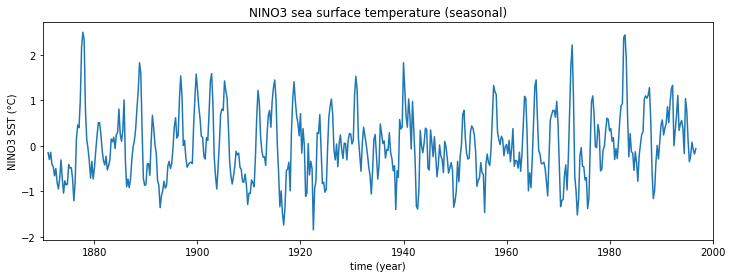

In [1]:
import numpy as np
from waveletFunctions import wavelet, wave_signif
import matplotlib.pyplot as plt
#from urllib2 import urlopen

#url = 'http://paos.colorado.edu/research/wavelets/wave_python/sst_nino3.dat'
#sst = np.loadtxt(urlopen(url))
# urlopen doesn't work on tmpnb.org, instead:
sst = np.loadtxt('sst_nino3.dat')
n = len(sst)
dt = 0.25
time = np.arange(len(sst)) * dt + 1871.0  # array of time epochs
xlim = ([1870, 2000])


%matplotlib inline
plt.figure(figsize=(12, 4))
plt.plot(time, sst)
plt.xlim(xlim[:])
plt.xlabel('time (year)')
plt.ylabel('NINO3 SST (°C)')
plt.title('NINO3 sea surface temperature (seasonal)')
plt.show()

Next continuous wavelet transform (CWT) of the time series is calculated. CWT of the discrete dataset $x_n$ may be evaluated as the convolution of $x_n$ and scaled and shifted mother wavelet $\psi_0(\eta)$:

$$ W_n(s) = \sum_{n'=0}^{N-1} x_{n'} \psi*\left[ \frac{(n'-n)\delta t}{s}\right].$$

Sampling interval of the SST time series is $\delta t = ¼$ year. 

## Scaling

Once the mother wavelet has been chosen, scales $s$ for calculation of the CWT must be selected. It is convenient to select scales as fractional powers of 2:

$$s_j = s_0 2^{j\delta j}, \quad j=0,1,...,J$$

where $s_0$ is the minimum scale and the maximum scale is determined by $J$. $s_0$ have to be selected such as the equivalent Fourier period  $\lambda$ will be approximately $2\delta t$.

In case of a Morlet wavelet the equivalent Fourier period belonging to scale $s$ is $4\pi s/(\omega_0 +\sqrt{2+\omega_0})$, which gives for $\omega_0=6$ while $\lambda = 1.03s$, hence to a good approximation $s_0 = ½$ years. One octave is subdivided into eight sub-octaves: $\delta j = 0.125$. $J = 56$, therefore overall 57 scales are analyzed (7 octaves):

In [2]:
pad = 1  # zero padding (recommended)
dj = 0.125  # 8 sub-octaves (within one octave)
s0 = 2 * dt  # 6 month initial scale
j1 = 7 / dj  # 7 octaves
mother = 'MORLET'

## Continuous wavelet transform

Fuction `wavelet()` in module `waveletFunctions.py` is used for the transform:

In [3]:
# Wavelet transform:
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother)
power = (np.abs(wave)) ** 2  # power spectrum (not quite correct)
scale_ext = np.outer(scale,np.ones(n))
power = (np.abs(wave))**2 /scale_ext  # power spectrum (corrected)

Plot wavelet power spectrum:

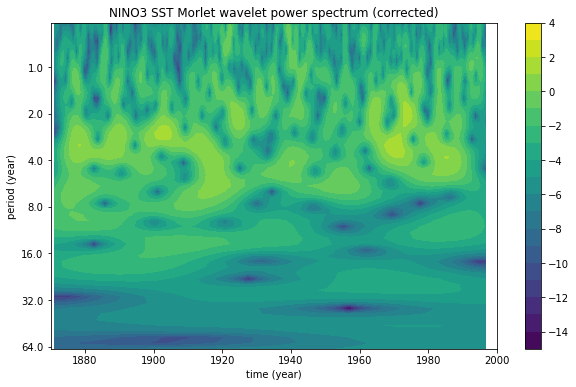

In [4]:
#--- wavelet power spectrum (contour and color plot)
import matplotlib
plt.figure(figsize=(10, 6))
levels = np.array([2**i for i in range(-15,5)])
CS = plt.contourf(time, period, np.log2(power), len(levels))  #*** or 'contour'
im = plt.contourf(CS, levels=np.log2(levels))
# im = plt.imshow(np.log2(np.flipud(power)),extent=[1870, 2000, 0.5, 64])
plt.xlabel('time (year)')
plt.ylabel('period (year)')
plt.title('NINO3 SST Morlet wavelet power spectrum (corrected)')
plt.xlim(xlim[:])
plt.yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.colorbar(im, orientation='vertical')
plt.show()

## How much does the result depend on the wavelet?

To answer this question let us make analysis with a DOG wavelet.

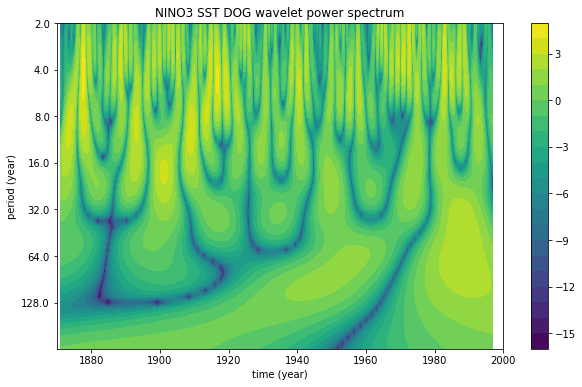

In [5]:
mother = 'DOG'
wave1, period1, scale1, coi1 = wavelet(sst, dt, pad, dj, s0, j1, mother)
power1 = (np.abs(wave1)) ** 2

# plot
plt.figure(figsize=(10, 6))
levels = np.array([2**i for i in range(-16,6)])
CS = plt.contourf(time, period1, np.log2(power1), len(levels))  #*** or 'contour'
im = plt.contourf(CS, levels=np.log2(levels))
#im = plt.imshow(np.log2(np.flipud(power)),extent=[1870, 2000, 2, 256])
plt.xlabel('time (year)')
plt.ylabel('period (year)')
plt.title('NINO3 SST DOG wavelet power spectrum')
plt.xlim(xlim[:])
plt.yscale('log', base=2, subs=None)
plt.ylim([np.min(period1), np.max(period1)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.colorbar(im, orientation='vertical')
plt.show()

## Are spectral peaks significant?

To make a null hypothesis a correct background spectrum must be selected:
* **white noise**  (uniform power on all frequencies)
* **red noise** (more power for low frequencies)

Next we assume that different realizations of the stochastic process fluctuate around this **exptected** (mean) **background spectrum**.
These mean spectra facilitate a significance test (on a given confidence level).

Significance levels are calculated with the `wave_signif()` function. One-step autocorrelation ($\alpha=0.72$) must be provided for the one dimensional AR(1) Markov process. This is estimated from the 1- and 2-step delay autocorrelations $\alpha_1$ and $\alpha_2$ of the El-Niño SST by the formula $\alpha=(\alpha_1 + \sqrt{\alpha_2})/2$. The AR(1) Markov process is

$$x_n=\alpha x_{n-1} + z_n,$$

where $x_0=0$ and $z_n$ is Gaussian white noise. This Markov process has the following discrete normalized power spectral density

$$P_k=\frac{1-\alpha^2}{1+\alpha^2-2\alpha\cos (2\pi k/N)},$$

where $k=0,... N/2$ denotes frequency index.



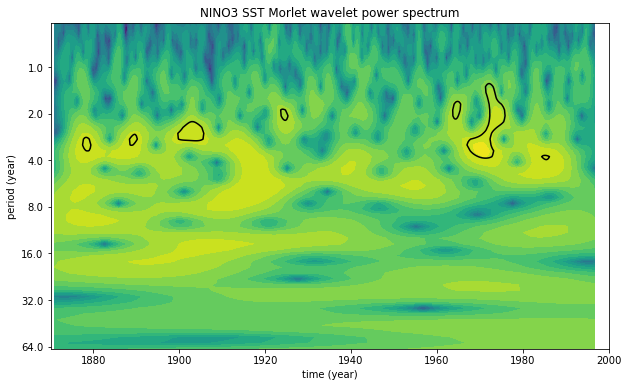

In [6]:
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, 'MORLET')
power = (np.abs(wave)) ** 2
# significance levels
signif = wave_signif(([1.0]), dt=dt, sigtest=0, scale=scale, lag1=0.72, mother='MORLET')
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
sig95 = power / sig95  # for > 1 values power is significant

# plot
plt.figure(figsize=(10, 6))
levels = np.array([2**i for i in range(-15,5)])
CS = plt.contourf(time, period, np.log2(power), len(levels))  #*** vagy 'contour'
im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('time (year)')
plt.ylabel('period (year)')
plt.title('NINO3 SST Morlet wavelet power spectrum')
plt.xlim(xlim[:])
plt.yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
# 95% significance level
plt.contour(time, period, sig95, [-99, 1], colors='k')
plt.show()

## Is normalization correct?

Fourier transform $\hat{\psi}_0$ of the mother wavelet $\psi_0$ is normalized for unit power

$$ \int_{-\infty}^{\infty}\left| \hat{\psi}_0(\omega')\right|^2 d\omega' = 1.$$

Parseval identity induces also normalized power of the mother wavelet

$$ \int_{-\infty}^{\infty}\left| \hat{\psi}_0(\omega')\right|^2 d\omega' = \int_{-\infty}^{\infty}\left| \psi_0(\eta)\right|^2 d\eta.$$

In order for CWT transform directly comparable for all scales $s$, scaled mother wavelets must also be normalized for unit power:

$$ \hat{\psi}(s \omega_k) = \left( \frac{2\pi s}{\delta t} \right)^{1/2} \hat{\psi}_0(s \omega_k)$$.

Let us check **wavelet power spectra** of **three sine functions with unit amplitudes but with different frequencies** (period $T$) 

$$x_n = \sin\left(2\pi\frac{n\delta t}{T_1} \right) + \sin\left(2\pi\frac{n\delta t}{T_2} \right) + \sin\left(2\pi\frac{n\delta t}{T_3} \right) $$


In [7]:
N = 512
dt = 0.25
t = np.arange(N) * dt
T1 = 1.0
T2 = 4.0
T3 = 16.0
w1 = 2 * np.pi / T1
w2 = 2 * np.pi / T2
w3 = 2 * np.pi / T3
s3 = np.sin(w1 * t) + np.sin(w2 * t) + np.sin(w3 * t)

pad = 1      # zero padding (recommended)
dj = 0.125   # 8 sub-octaves
s0 = 2*dt    # 6 month initial scale
j1 = 7/dj    # 7 octaves
mother = 'MORLET'  # mother wavelet
wave, period, scale, coi = wavelet(s3, dt, pad, dj, s0, j1, mother)
power = (np.abs(wave)) ** 2

Plot the signal and its wavelet spectrum:

SyntaxError: invalid syntax (<ipython-input-11-c1ee71fca694>, line 31)

It is clearly seen that CWT of the three sine functions with the same amplitude is far from having identical power. This problem is discussed in the paper of Liu et al.(2007): Rectification of the Bias in the Wavelet Power Spectrum *Journal of Atmospheric and Oceanic Technology*, 24(12), 2093-2102, which can be downloaded from the author's [homepage](http://ocgweb.marine.usf.edu/~liu/wavelet.html).

Liu et al. proposed instead of the usual $|W_n(s)|^2$ normalization to use the following one: $1/s_j\;|W_n(s)|^2$ (CWT power is multiplied by the inverse of scale).

Let us see what happens with this alternative normalization in the example we are discussing.

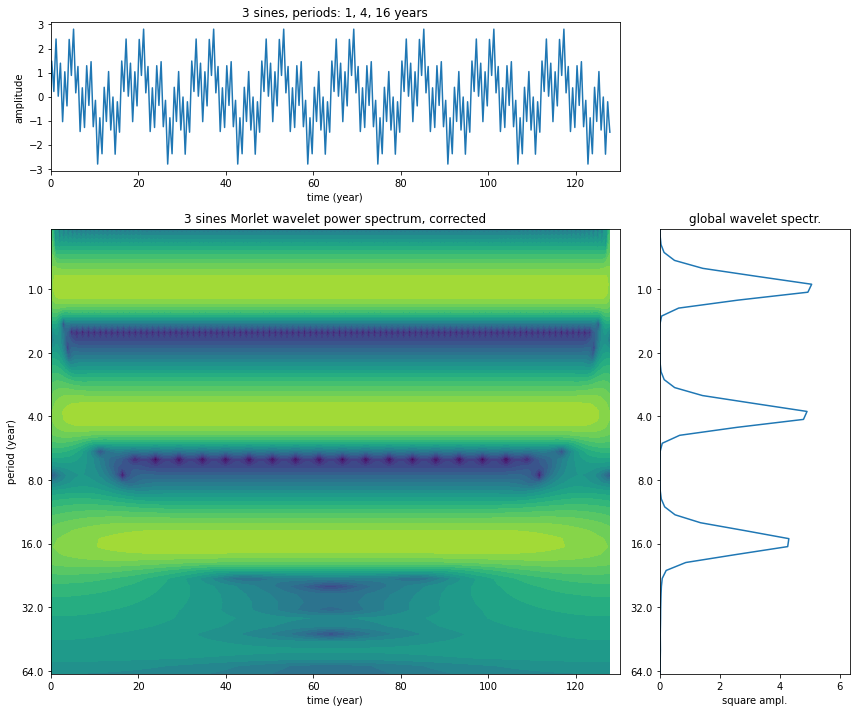

In [12]:
scale_ext = np.outer(scale,np.ones(N))
power = (np.abs(wave))**2 /scale_ext  # power spectrum (corected)
global_ws = variance * (np.sum(power, axis=1) / n)  # time averaged global spectrum

gs = gridspec.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[1,3])

#--- signal
xlim = ([0, 130])
plt.figure(figsize=(12, 10))
plt.subplot(gs[0,0])
plt.plot(t, s3)
plt.xlim(xlim[:])
plt.xlabel('time (year)')
plt.ylabel('amplitude')
plt.title('3 sines, periods: 1, 4, 16 years')

#--- wavelet power spectrum
plt3 = plt.subplot(gs[1,0])
levels = np.array([2**i for i in range(-20,6)])
CS = plt.contourf(t, period, np.log2(power), len(levels))  #*** or use 'contour'
im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('time (year)')
plt.ylabel('period (year)')
plt.title('3 sines Morlet wavelet power spectrum, corrected')
plt.xlim(xlim[:])
# format y-scale
plt3.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
plt3.invert_yaxis()

#--- global wavelet spectrum
plt4 = plt.subplot(gs[1,1])
plt.plot(global_ws, period)
plt.xlabel('square ampl.')
#plt.ylabel('period (year)')
plt.title('global wavelet spectr.')
plt.xlim([0, 1.25 * np.max(global_ws)])
# format y-scale
plt4.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt4.invert_yaxis()

plt.tight_layout()

plt.show()


Now the sines almost have the same power. But there is a problem. *Corrected* spectrum of white noise is not uniform in power for all frequencies, hence **not corrected** power is required for significance testing.

(Excercise: Verify the above statement with the calculation of continuous wavelet transforms of gaussian white noise according to the two normalizations. The results can be seen in the following figure:)

![Different normalizations of white noise](wn_en.png "CWT of gaussian white noise with different normalizations")


## Cone of influence

For a finite dataset both ends of the wavelet spectrum will be distorted, since Fourier transform asssumes a dataset which is **periodic**. One possible solution is zero padding before the transform and subsequent removal. Zero padding introduces jumps at both endpoints and for larger scales it decreases more and more the amplitudes near the edges. **Cone of influence** (COI) is that part of the wavelet spectrum where edge effects become significant. It is defined as the time for which at a given scale wavelet autocorrelation reduces to $1/e$ and power to $1/e^2$. No zero padding is necessary for datasets with periodicity, hence there is no cone of influence for such datasets.

Calculate and plot the cone of influence for the El-Niño SST data (corrected power spectrum).

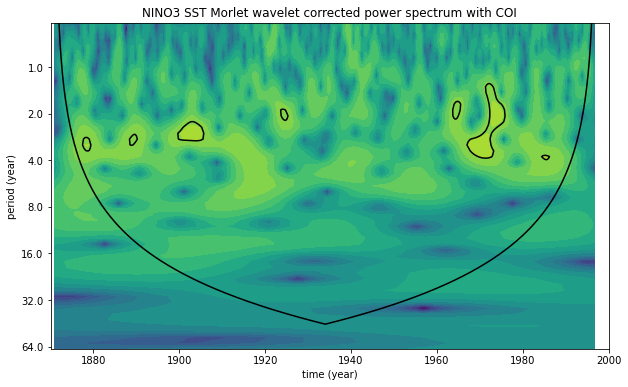

In [13]:
n = len(sst)
dt = 0.25
time = np.arange(len(sst)) * dt + 1871.0  # array of time epochs
xlim = ([1870, 2000])

wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, 'MORLET')
power = (np.abs(wave)) ** 2
# significance levels - calculated with uncorrected spectrum!
signif = wave_signif(([1.0]), dt=dt, sigtest=0, scale=scale, lag1=0.72, mother='MORLET')
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
sig95 = power / sig95  # power is significant where > 1

scale_ext = np.outer(scale,np.ones(n))
power = (np.abs(wave))**2 /scale_ext  # power spectrum (corrected)

# ábra
plt.figure(figsize=(10, 6))
levels = np.array([2**i for i in range(-15,5)])
CS = plt.contourf(time, period, np.log2(power), len(levels))  #*** or 'contour'
im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('time (year)')
plt.ylabel('period (year)')
plt.title('NINO3 SST Morlet wavelet corrected power spectrum with COI')
plt.xlim(xlim[:])
plt.yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
# 95% significance level
plt.contour(time, period, sig95, [-99, 1], colors='k')
# Cone of influence (COI)
plt.plot(time, coi[:-1], 'k')
plt.show()

## Phase

Phases of complex Morlet wavelet spectrum can also be plotted. This plot shows places of identical phase of the wavelet transform (wave crests and troughs).

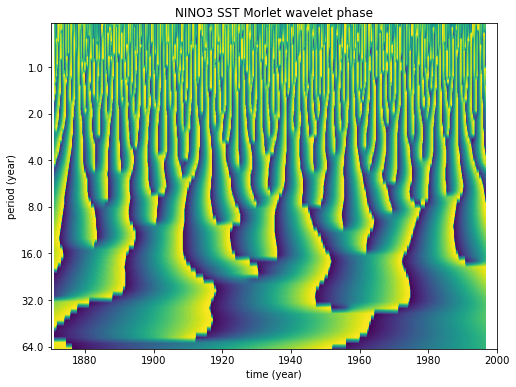

In [14]:
phase = (np.angle(wave))

plt.figure(figsize=(8, 6))
levels = np.arange(-np.pi,np.pi,0.1)
CS = plt.contourf(time, period, phase, len(levels))  #*** or 'contour'
im = plt.contourf(CS, levels=levels)
plt.xlabel('time (year)')
plt.ylabel('period (year)')
plt.title('NINO3 SST Morlet wavelet phase')
plt.xlim(xlim[:])
plt.yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.show()

## Inverse wavelet transform (reconstruction)

In case of a non-orthogonal wavelet transform base, as is the CWT, inversion is redundant: time series reconstruction can be accomplished with *different* wavelet functions. The most simple inverse CWT (iCWT) uses the delta function($\delta$). Reconstructed time series is the sum of real parts of the wavelet transform at different scales for all the scales:

$$ x_n=\frac{\delta j \delta t^{1/2}}{C_\delta \psi_0(0)} \sum_{j=0}^J \frac{\Re \left\{ W_n(s_j) \right\} }{s_j^{1/2}}$$

The factor $\psi_0(0)$ eliminates scaling by power and $s_j^{1/2}$ converts wavelet transform to energy density while the factor $C_\delta$ depends upon the type of the wavelet.

Let us calcuate the **inverse wavelet transform of the SST data**. First we define a  Python function for the reconstruction (this is not included in the Python code written by Evgeniya Predybaylo):

In [15]:
def icwt(W, sj, dt, dj=1/8, mother='morlet'):
    """
    Continuous inverse wavelet transform.

    Parameters
    ----------
    W : wavelet transform
    sj : vector of scales
    dt : sampling interval
    dj : discrete scale interval, default is 0.125.
    mother : mother wavelet (default: Morlet)
    
    Result
    --------
    iW : inverse wavelet transform
    """
    mother = mother.upper()
    if mother == 'MORLET':
        Cd = 0.7785  
        psi0 = 0.751126
    elif mother == 'PAUL': # Paul, m=4
        Cd = 1.132
        psi0 = 1.07894
    elif mother == 'DOG':   # Dog, m=2
        Cd = 3.541
        psi0 = 0.86733
    else:
        raise Error('Mother must be one of Morlet, Paul, DOG')

    a, b = W.shape
    c = sj.size
    if a == c:
        sj = (np.ones([b, 1]) * sj).transpose()
    elif b == c:
        sj = np.ones([a, 1]) * sj
    else:
        raise Warning('Input array dimensions do not match.')

    # Torrence és Compo (1998), eq. (11)
    iW = dj * np.sqrt(dt) / (Cd * psi0) * (
        np.real(W) / np.sqrt(sj)).sum(axis=0)
    return iW

Let us calculate the reconstructed time series. Plot the original dataset, the reconstructed dataset and the differences:

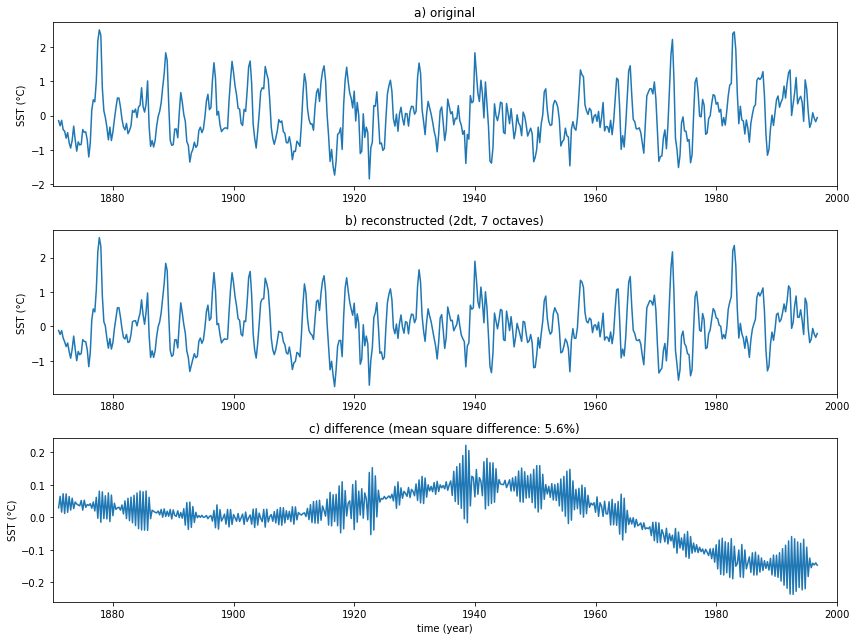

In [16]:
s0 = 2 * dt   # 6 months initial scale
j1 = 7 / dj   # 7 octaves

wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother)

# inverse wavelet transform
x = icwt(wave, scale, dt, dj, 'morlet')

# original dataset
plt.figure(figsize=(12, 9))
plt.subplot(311)
plt.plot(time, sst)
plt.xlim(xlim[:])
plt.ylabel('SST (°C)')
plt.title('a) original')

# reconstructed dataset
plt.subplot(312)
plt.plot(time, x)
plt.xlim(xlim[:])
#plt.xlabel('time (year)')
plt.ylabel('SST (°C)')
plt.title('b) reconstructed (2dt, 7 octaves)')

# difference
plt.subplot(313)
plt.plot(time, x-sst)
plt.xlim(xlim[:])
plt.xlabel('time (year)')
plt.ylabel('SST (°C)')
plt.title('c) difference (mean square difference: 5.6%)')
plt.tight_layout()

plt.show()

Standard deviation of differences with respect to signal variance expressed as percent may be a good characteristic of reconstruction errors:

In [17]:
# mean square reconstruction error in percent
print ("mean square reconstruction error = %.3f %%" % (100*np.std(x-sst)/variance))

mean square reconstruction error = 5.578 %


Reconstruction errors can be reduced by changing CWT parameters: a smaller initial scale $s_0$ is used or the analysis is made over more octaves.

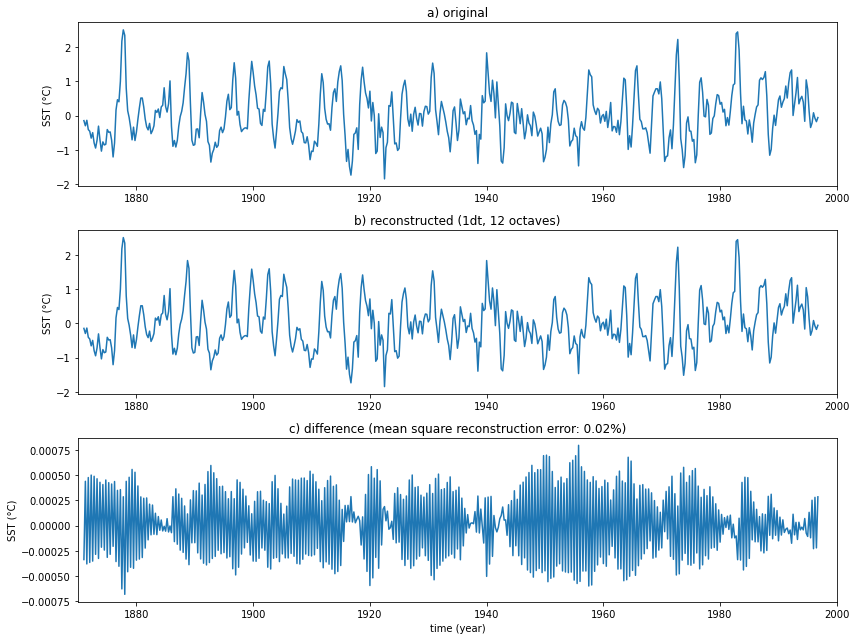

mean square reconstruction error = 0.023 %


In [18]:
s0 = 2*dt/2.0  # 3 months initial scale
j1 = 12 / dj  # 12 octaves
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother)

# inverse wavelet transform
x = icwt(wave, scale, dt, dj, 'morlet')

# original dataset
plt.figure(figsize=(12, 9))
plt.subplot(311)
plt.plot(time, sst)
plt.xlim(xlim[:])
plt.ylabel('SST (°C)')
plt.title('a) original')

# reconstructed dataset
plt.subplot(312)
plt.plot(time, x)
plt.xlim(xlim[:])
#plt.xlabel('time (year)')
plt.ylabel('SST (°C)')
plt.title('b) reconstructed (1dt, 12 octaves)')

# difference
plt.subplot(313)
plt.plot(time, x-sst)
plt.xlim(xlim[:])
plt.xlabel('time (year)')
plt.ylabel('SST (°C)')
plt.title('c) difference (mean square reconstruction error: 0.02%)')
plt.tight_layout()

plt.show()

# mean square reconstruction error in percent
print ("mean square reconstruction error = %.3f %%" % (100*np.std(x-sst)/variance))

## Additional topics

* Filtering by wavelets
* Global wavelet spectrum (time and scale averaging, smoothing)
* Cross wavelet spectrum, coherence
* Multivariate (complex) continuous WT
* Discrete diadic WT, scaling functions
* Multiresolution analysis (MRA)
* Wavelet operator compression
* Analyze own data with wavelets